In [1]:
%load_ext autoreload
%autoreload 2
# import torch; torch.manual_seed(955)
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from dataGen import Gen, FastGen, Gen2
from Encoders import LongShort_TCVAE_Encoder, RnnEncoder, MST_VAE_Encoder, MST_VAE_Encoder_dist
from Decoders import LongShort_TCVAE_Decoder, RnnDecoder, MST_VAE_Decoder, MST_VAE_Decoder_dist
from vae import Variational_Autoencoder, VQ_MST_VAE, VQ_Quantizer
from utils import * #train_on_effect, generate_data, extract_parameters, suppress_prints, add_mu_std
from train import *
from disentangelement import *
import argparse
import numpy as np
import matplotlib.pyplot as plt
import pprint
torch.set_printoptions(sci_mode=False)

# all parameters for generating the time series should be configured in this cell
        
p=730       
args = GENV(n_channels=1,
            latent_dims=5,
            n_samples=500,
            shuffle=False,
            periode=p,
            step=60*24*7,
            L=15,
            min_max=True,
            num_layers=2,
            ß=3,
            modified=False,
            split = (0.5,0.6),
            window=SlidingWindow,
            first_kernel=10)
effects = {
    "Pulse": {
        "occurances":1,
        "max_amplitude":5,   
        "interval":40,
        "start":None
        },
    "Trend": {
        "occurances":10,
        "max_slope":0.002,
        "type":"linear",
        "start":None
        },
    "Seasonality": {
        "occurances":10,
        "frequency_per_week":(56, 63), # min and max occurances per week
        "amplitude_range":(5, 20),
        "start":-5
        },
    "std_variation": {
        "occurances":0,
        "max_value":10,
        "interval":30,
        "start":None
        },
    "channels_coupling":{
        "occurances":0,
        "coupling_strengh":20
        },
    "Noise": {
        "occurances":0,
        "max_slope":0.005,
        "type":"linear"
        }
    }

In [2]:
from importlib import reload
from Encoders import LongShort_TCVAE_Encoder#, RnnEncoder, MST_VAE_Encoder, MST_VAE_Encoder_dist
from Decoders import LongShort_TCVAE_Decoder#, RnnDecoder, MST_VAE_Decoder, MST_VAE_Decoder_dist
from vae import Variational_Autoencoder, VQ_MST_VAE, VQ_Quantizer
args.num_embed = 512# args.enc_out**2 
args.robust = False
vae = Variational_Autoencoder(args,
                            v_encoder = LongShort_TCVAE_Encoder, #MST_VAE_Encoder,
                            v_decoder = LongShort_TCVAE_Decoder #MST_VAE_Decoder,
                           )
vq = VQ_MST_VAE(args,
                v_encoder = LongShort_TCVAE_Encoder, #MST_VAE_Encoder,
                v_decoder = LongShort_TCVAE_Decoder, #MST_VAE_Decoder,
                v_quantizer = VQ_Quantizer) #10 5

vae = vae.to(args.device)
vq = vq.to(args.device)

opt_vae = optim.Adam(vae.parameters(), lr = 0.002043529186448577) # 0.005043529186448577 0.006819850049647945
opt_vq = optim.Adam(vq.parameters(), lr = 0.002043529186448577) # 0.005043529186448577 0.006819850049647945

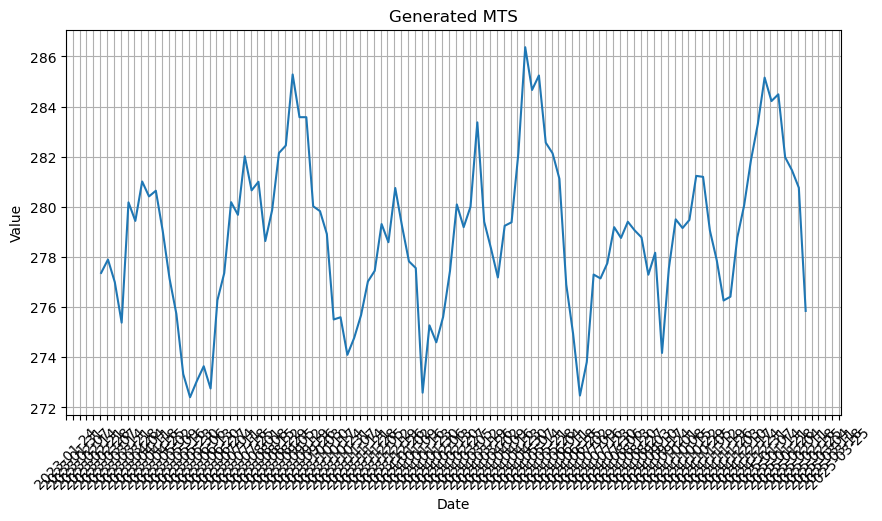

torch.Size([1, 42])
torch.Size([1, 52])
torch.Size([1, 10])
torch.Size([1, 42])


In [3]:
train_data_long, val_data_long, test_data_long, X_long = generate_long_data(args,
                                                                            effects,
                                                                            effect="Seasonality",
                                                                            occurance=10,
                                                                            return_gen=True,
                                                                            periode_factor=1,
                                                                            anomalies=False)

In [4]:
x, params, e_params = X_long.parameters()
x.shape

(1, 1, 104)

In [5]:
def pick_data_prediction(data_tup, args):
    if args.min_max:
        data_curr = data_tup[0].to(args.device)
        data_next = data_tup[1].to(args.device)
    else:
        data_curr = data_tup[2].to(args.device)
        data_next = data_tup[3].to(args.device)
    return data_curr, data_next


def train_prediction(model, train_loader, args, optimizer, epoch):
    device = args.device
    model.train()
    for p in model.parameters():
        p.requires_grad = True
    train_loss = 0

    for batch_idx, (data_tup, labels, norm) in enumerate(train_loader):
        
        data_curr, data_next = pick_data_prediction(data_tup, args)
        norm = [n.to(device) for n in norm]
        optimizer.zero_grad()
        

        x_rec, loss, mu, logvar, mu_rec, logvar_rec, e = model(data_curr, data_next)


        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        if batch_idx % 100 == 0:
            #             print("True Loss: ", loss.item())
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t True Loss: {:.6f}'.format(
                epoch, batch_idx, len(train_loader),
                100. * batch_idx / len(train_loader), loss.item() / len(data_curr), loss.item()))
#     print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

    return train_loss / len(train_loader.dataset)

In [ ]:
args.min_max=False
np.set_printoptions(suppress=True)
VAE_losses = []
VQ_losses = []

for epoch in range(1, 1000):
    loss_vae = train_prediction(vae, train_data_long, args, opt_vae, epoch)
    loss_vq = train_prediction(vq, train_data_long, args, opt_vq, epoch)
    
#     if epoch%50 == 1:
#         display.clear_output(wait=True)
#         show_results_long(vae, train_data_long, args)
#         show_results_long(vq, train_data_long, args, vq=True)
        
    VAE_losses.append(loss_vae)
    VQ_losses.append(loss_vq)
        
    print('====> VAE: Sample {} Average loss: {:.4f}'.format(epoch, loss_vae / len(train_data_long.dataset)))
    print('====> VQ: Sample {} Average loss: {:.4f}'.format(epoch, loss_vq / len(train_data_long.dataset)))

Train Epoch: 1 [0/1 (0%)]	Loss: 28.955240	 True Loss: 1071.343872
Train Epoch: 1 [0/1 (0%)]	Loss: 37.749116	 True Loss: 1396.717285
====> VAE: Sample 1 Average loss: 0.7826
====> VQ: Sample 1 Average loss: 1.0202
Train Epoch: 2 [0/1 (0%)]	Loss: 27.873228	 True Loss: 1031.309448
Train Epoch: 2 [0/1 (0%)]	Loss: 36.060841	 True Loss: 1334.251099
====> VAE: Sample 2 Average loss: 0.7533
====> VQ: Sample 2 Average loss: 0.9746
Train Epoch: 3 [0/1 (0%)]	Loss: 28.534397	 True Loss: 1055.772705
Train Epoch: 3 [0/1 (0%)]	Loss: 34.884670	 True Loss: 1290.732788
====> VAE: Sample 3 Average loss: 0.7712
====> VQ: Sample 3 Average loss: 0.9428
Train Epoch: 4 [0/1 (0%)]	Loss: 28.825743	 True Loss: 1066.552490
Train Epoch: 4 [0/1 (0%)]	Loss: 35.609896	 True Loss: 1317.566162
====> VAE: Sample 4 Average loss: 0.7791
====> VQ: Sample 4 Average loss: 0.9624
Train Epoch: 5 [0/1 (0%)]	Loss: 28.641130	 True Loss: 1059.721802
Train Epoch: 5 [0/1 (0%)]	Loss: 34.291695	 True Loss: 1268.792725
====> VAE: Sampl

Train Epoch: 40 [0/1 (0%)]	Loss: 22.837562	 True Loss: 844.989807
Train Epoch: 40 [0/1 (0%)]	Loss: 30.711281	 True Loss: 1136.317383
====> VAE: Sample 40 Average loss: 0.6172
====> VQ: Sample 40 Average loss: 0.8300
Train Epoch: 41 [0/1 (0%)]	Loss: 21.635209	 True Loss: 800.502747
Train Epoch: 41 [0/1 (0%)]	Loss: 28.351460	 True Loss: 1049.004028
====> VAE: Sample 41 Average loss: 0.5847
====> VQ: Sample 41 Average loss: 0.7663
Train Epoch: 42 [0/1 (0%)]	Loss: 21.871681	 True Loss: 809.252197
Train Epoch: 42 [0/1 (0%)]	Loss: 3111.567356	 True Loss: 115127.992188
====> VAE: Sample 42 Average loss: 0.5911
====> VQ: Sample 42 Average loss: 84.0964
Train Epoch: 43 [0/1 (0%)]	Loss: 21.867745	 True Loss: 809.106567
Train Epoch: 43 [0/1 (0%)]	Loss: 39.994025	 True Loss: 1479.778931
====> VAE: Sample 43 Average loss: 0.5910
====> VQ: Sample 43 Average loss: 1.0809
Train Epoch: 44 [0/1 (0%)]	Loss: 23.032525	 True Loss: 852.203430
Train Epoch: 44 [0/1 (0%)]	Loss: 29.689156	 True Loss: 1098.49877

Train Epoch: 78 [0/1 (0%)]	Loss: 26.407566	 True Loss: 977.079956
====> VAE: Sample 78 Average loss: 0.4870
====> VQ: Sample 78 Average loss: 0.7137
Train Epoch: 79 [0/1 (0%)]	Loss: 16.939590	 True Loss: 626.764832
Train Epoch: 79 [0/1 (0%)]	Loss: 25.486122	 True Loss: 942.986511
====> VAE: Sample 79 Average loss: 0.4578
====> VQ: Sample 79 Average loss: 0.6888
Train Epoch: 80 [0/1 (0%)]	Loss: 16.812894	 True Loss: 622.077087
Train Epoch: 80 [0/1 (0%)]	Loss: 24.612613	 True Loss: 910.666687
====> VAE: Sample 80 Average loss: 0.4544
====> VQ: Sample 80 Average loss: 0.6652
Train Epoch: 81 [0/1 (0%)]	Loss: 16.503781	 True Loss: 610.639893
Train Epoch: 81 [0/1 (0%)]	Loss: 23.977473	 True Loss: 887.166504
====> VAE: Sample 81 Average loss: 0.4460
====> VQ: Sample 81 Average loss: 0.6480
Train Epoch: 82 [0/1 (0%)]	Loss: 17.328709	 True Loss: 641.162231
Train Epoch: 82 [0/1 (0%)]	Loss: 22.322972	 True Loss: 825.949951
====> VAE: Sample 82 Average loss: 0.4683
====> VQ: Sample 82 Average loss

Train Epoch: 118 [0/1 (0%)]	Loss: 16.373555	 True Loss: 605.821533
====> VAE: Sample 118 Average loss: 0.3925
====> VQ: Sample 118 Average loss: 0.4425
Train Epoch: 119 [0/1 (0%)]	Loss: 14.753921	 True Loss: 545.895081
Train Epoch: 119 [0/1 (0%)]	Loss: 186.812988	 True Loss: 6912.080566
====> VAE: Sample 119 Average loss: 0.3988
====> VQ: Sample 119 Average loss: 5.0490
Train Epoch: 120 [0/1 (0%)]	Loss: 15.493100	 True Loss: 573.244690
Train Epoch: 120 [0/1 (0%)]	Loss: 18.037758	 True Loss: 667.397034
====> VAE: Sample 120 Average loss: 0.4187
====> VQ: Sample 120 Average loss: 0.4875
Train Epoch: 121 [0/1 (0%)]	Loss: 14.817051	 True Loss: 548.230896
Train Epoch: 121 [0/1 (0%)]	Loss: 16.172197	 True Loss: 598.371277
====> VAE: Sample 121 Average loss: 0.4005
====> VQ: Sample 121 Average loss: 0.4371
Train Epoch: 122 [0/1 (0%)]	Loss: 14.684527	 True Loss: 543.327515
Train Epoch: 122 [0/1 (0%)]	Loss: 17.846584	 True Loss: 660.323608
====> VAE: Sample 122 Average loss: 0.3969
====> VQ: Sa

Train Epoch: 156 [0/1 (0%)]	Loss: 12.848666	 True Loss: 475.400635
Train Epoch: 156 [0/1 (0%)]	Loss: 16.270297	 True Loss: 602.000977
====> VAE: Sample 156 Average loss: 0.3473
====> VQ: Sample 156 Average loss: 0.4397
Train Epoch: 157 [0/1 (0%)]	Loss: 13.462912	 True Loss: 498.127747
Train Epoch: 157 [0/1 (0%)]	Loss: 18.569951	 True Loss: 687.088196
====> VAE: Sample 157 Average loss: 0.3639
====> VQ: Sample 157 Average loss: 0.5019
Train Epoch: 158 [0/1 (0%)]	Loss: 14.298459	 True Loss: 529.042969
Train Epoch: 158 [0/1 (0%)]	Loss: 16.861975	 True Loss: 623.893066
====> VAE: Sample 158 Average loss: 0.3864
====> VQ: Sample 158 Average loss: 0.4557
Train Epoch: 159 [0/1 (0%)]	Loss: 12.608459	 True Loss: 466.512970
Train Epoch: 159 [0/1 (0%)]	Loss: 15.679572	 True Loss: 580.144165
====> VAE: Sample 159 Average loss: 0.3408
====> VQ: Sample 159 Average loss: 0.4238
Train Epoch: 160 [0/1 (0%)]	Loss: 11.924464	 True Loss: 441.205170
Train Epoch: 160 [0/1 (0%)]	Loss: 16.206974	 True Loss: 5

In [ ]:
def rebuild_TS_prediction(model, train_loader, args, keep_norm= False):
    device = args.device
    L = args.L
    n_channels = args.n_channels
    data_shape = train_loader.dataset.data.shape 
    min_max = args.min_max
    
    model.to(device)
    model.eval()
    for p in model.parameters():
        p.requires_grad = False
        
    e_indices = torch.empty(args.enc_out, 0).to(device)

    Origin = torch.empty(n_channels, 0).to(device)
    REC = torch.empty(n_channels, 0).to(device)

    idx = 0
    for sample_idx, (data_tup, label, norm) in enumerate(train_loader):       
        if keep_norm:
            norm = mute_norm(norm)

        data_curr, data_next = pick_data_prediction(data_tup, args)        
        norm = [n.to(device) for n in norm]
        
        x_rec, loss, mu, logvar, mu_rec, logvar_rec, e, indices = model(data_curr, data_next, ouput_indices=True)
        
        denorm_data = revert_min_max(data_curr, norm) if min_max else revert_standarization(data_curr, norm)
        denorm_rec =  revert_min_max(x_rec, norm) if min_max else revert_standarization(x_rec, norm)

        first_data = denorm_data[0, args.n_channels-1, :].reshape(args.n_channels, -1)
        first_rec = denorm_rec[0, args.n_channels-1, :].reshape(args.n_channels, -1)

    # Keep only the last point for all remaining batches
        rest = denorm_data[1:, args.n_channels-1, -1].reshape(args.n_channels, -1)
        rest_rec = denorm_rec[1:, args.n_channels-1, -1].reshape(args.n_channels, -1)
        
        Origin    = torch.cat(( first_data, rest ), axis=1)
        REC       = torch.cat(( first_rec, rest_rec ), axis=1)

    return Origin.T, REC.T, e_indices

In [61]:
Origin_norm, REC_norm, _ = rebuild_TS_prediction(vq, test_data_long, args, keep_norm=True)
Origin, REC, indices = rebuild_TS_prediction(vq, test_data_long, args)

In [62]:
Origin.shape

torch.Size([41, 1])

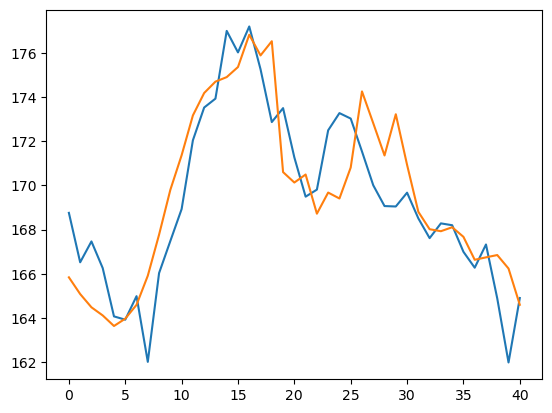

In [63]:
plt.plot(Origin)
plt.plot(REC)